In [1]:
import os; work_dir = "../../"; os.chdir(work_dir); work_dir = os.getcwd(); print("Current working directory:", work_dir)

Current working directory: /home/wilf/Desktop/python_workspace/PCD_SM-Fluid-Pred


In [2]:
import numpy as np
import matplotlib.pyplot as plt
from results.data import multiple_GT_loading, make_results_dicts, load_multiple_results

loadKwargs = dict(storage_path="./storage", dataset_name="turbulent_radiative_layer_2D")

IDs = ['y2025_m04_d27_23h_30m_37s', 'y2025_m04_d02_09h_25m_13s', 'y2025_m04_d28_03h_18m_54s',
       'y2025_m04_d24_10h_54m_08s', 'y2025_m04_d24_16h_28m_53s', 'y2025_m04_d24_19h_19m_14s']


# WARNING: order of iteration must match IDs order
method_strings = ["E_loss_False__ODE_False", "E_loss_True__ODE_False"]
regularization = ["regFalse", "regTrue"]
sde_names = ["vpsde", "subvpsde", "vesde"]

In [3]:
test_cases = [1,2,3]

# ORDER (fields): velocity (x,y), density, pressure, ORDER (params): mach
mean = np.array([3.4847e+01, 9.4475e-01, 6.1707e-03, -2.4651e-02], dtype=np.float32)
std =  np.array([4.4284e+01, 6.0970e-02, 4.1764e-02, 4.0095e-02], dtype=np.float32)

dataKwargs = dict(test_cases=test_cases, means=mean, stds=std, dataset_name="turbulent_radiative_layer_2D")
GTs, fields_name = multiple_GT_loading(any_method_string=method_strings[0], any_ID=IDs[0], any_version=1, **dataKwargs)
GT_1, GT_2, GT_3 = GTs[1], GTs[2], GTs[3]

# Form: test_set = {"GT": {"pred": GT_1}, "regFalse": {sde: {} for sde in sde_names}, "regTrue": {sde: {} for sde in sde_names}}
empty_test_sets = make_results_dicts(GTs, regularization, sde_names, test_cases)  # test_set_1, ... = empty_test_sets[1], ...

In [4]:
versions = [1,2,3,4,5]  # Add as many samples as you can

dataKwargs = dict(means=mean, stds=std, dataset_name="turbulent_radiative_layer_2D", mask=(mask:=GTs["mask"]))
casesKwargs = dict(empty_test_sets=empty_test_sets, versions=versions, test_cases=test_cases)
test_sets = load_multiple_results(method_strings, IDs, regularization, sde_names, **casesKwargs, **dataKwargs)

test_set_1, test_set_2, test_set_3 = test_sets[1], test_sets[2], test_sets[3]  # e.g.

In [5]:
from results.operations import GT_measures, pred_measures

n_bins = 200

GT_measures(test_set_1, fields_name, n_bins, dataset_name="turbulent_radiative_layer_2D")
GT_measures(test_set_2, fields_name, n_bins, dataset_name="turbulent_radiative_layer_2D")
GT_measures(test_set_3, fields_name, n_bins, dataset_name="turbulent_radiative_layer_2D")

perona=False

for version in versions:  # e.g. test_set_1["regTrue"]["vpsde"]["spatial_histogram"][42][2], the 3rd field
    pred_measures(test_set_1, version, regularization, sde_names, fields_name, n_bins, perona=perona, dataset_name="turbulent_radiative_layer_2D")
    pred_measures(test_set_2, version, regularization, sde_names, fields_name, n_bins, perona=perona, dataset_name="turbulent_radiative_layer_2D")
    pred_measures(test_set_3, version, regularization, sde_names, fields_name, n_bins, perona=perona, dataset_name="turbulent_radiative_layer_2D")

# After key measure is input, input [version] except for GT

/home/wilf/anaconda3/envs/SM-Fluid-Pred/lib/python3.10/site-packages/numpy/lib/_histograms_impl.py:901: RuntimeWarning: invalid value encountered in divide
  return n/db/n.sum(), bin_edges
/home/wilf/Desktop/python_workspace/PCD_SM-Fluid-Pred/results/operations.py:364: RuntimeWarning: invalid value encountered in cast
  dict_in["GT"]["spatial_histogram"][field][t, :] = hist_counts
/home/wilf/Desktop/python_workspace/PCD_SM-Fluid-Pred/results/operations.py:649: RuntimeWarning: invalid value encountered in cast
  dict_in[regu][sde]["spatial_histogram"][version][field][t, :] = hist_counts


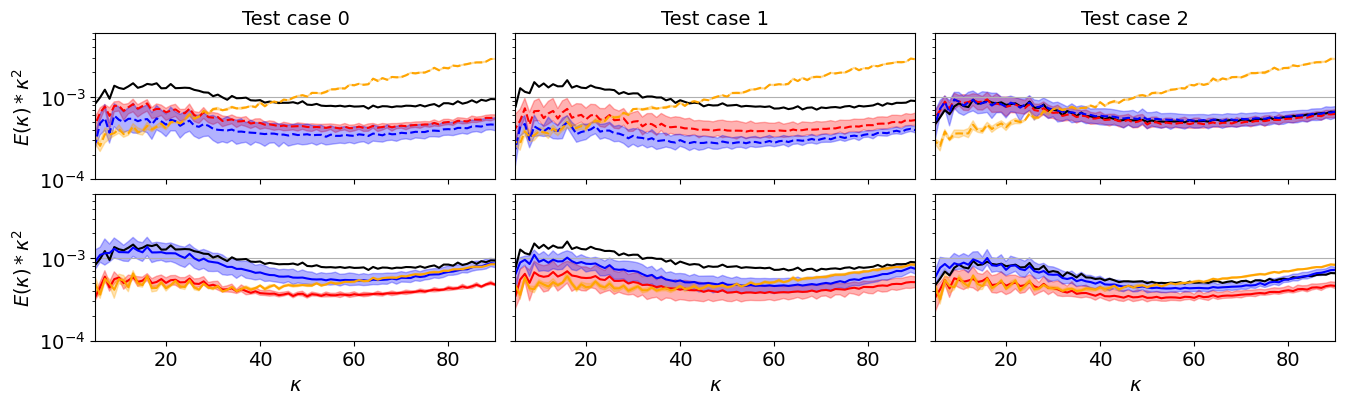

In [6]:
test_cases = [test_set_1, test_set_2, test_set_3]
version = 1

fs_label = 14
fs_titles = 14
fs_x_label = 14
fs_y_label = 14
fs_ticks = 14
fs_legend = 14


fac = 2
fig, axes = plt.subplots(2,3, figsize=(8*fac,2*fac))

axes[0,0].set_ylabel(r"$E(\kappa)*\kappa^{2}$", fontsize=fs_y_label)
axes[1,0].set_ylabel(r"$E(\kappa)*\kappa^{2}$", fontsize=fs_y_label)
alpha_kolmogorov = 1e6
colors = ["red", "blue", "orange"]

for i, ax in enumerate(axes[0,:]):

    test_case = test_cases[i]

    k, E_k_GT = test_case["GT"]["spectra"]["k"], test_case["GT"]["spectra"]["E_k"]
    # ax.loglog(k, E_k_GT + 1e-16, label="Ground truth", color="black", linestyle="-", markersize=3, markevery=5, zorder=100)
    ax.plot(k, E_k_GT * np.square(k), color="black")

    for ii, sde in enumerate(sde_names):
        k_i, E_k_i = test_case["regFalse"][sde]["spectra"][version]["k"], test_case["regFalse"][sde]["spectra"][version]["E_k"]
        # ax.loglog(k, E_k_i + 1e-16, color=colors[ii], linestyle="--")

        data = np.stack([test_case["regFalse"][sde]["spectra"][v]["E_k"] * np.square(k) for v in versions ], axis=0)  # shape: (n_versions, n_points)
        mean_y = np.mean(data, axis=0)
        low, high = np.percentile(data, 5, axis=0), np.percentile(data, 95, axis=0)

        ax.fill_between(k, low, high, color=colors[ii], alpha=0.3)

        ax.plot(k, mean_y, color=colors[ii], linestyle="--")

    ax.set_title('Test case ' + str(i), fontsize=fs_titles)

    # ax.set_xscale('log', base=2)
    ax.set_yscale('log')


    if i>0: ax.set_yticklabels([])
    ax.set_xticklabels([])


for i, ax in enumerate(axes[1,:]):

    test_case = test_cases[i]

    k, E_k_GT = test_case["GT"]["spectra"]["k"], test_case["GT"]["spectra"]["E_k"]
    ax.plot(k, E_k_GT * np.square(k), color="black")

    for ii, sde in enumerate(sde_names):
        data = np.stack([test_case["regTrue"][sde]["spectra"][v]["E_k"] * np.square(k) for v in versions ], axis=0)  # shape: (n_versions, n_points)
        mean_y = np.mean(data, axis=0)
        low, high = np.percentile(data, 5, axis=0), np.percentile(data, 95, axis=0)

        ax.fill_between(k, low, high, color=colors[ii], alpha=0.3)

        ax.plot(k, mean_y, color=colors[ii], linestyle="-")

    ax.set_xlabel(r"$\kappa$", fontsize=fs_x_label)

    # ax.set_xscale('log', base=2)
    ax.set_yscale('log')

    if i>0: ax.set_yticklabels([])

for ax in axes.flatten():

    ax.set_ylim(10e-5*1, 10e-4*6)
    ax.set_xlim(5, 90)
    # ax.set_xticklabels(list(np.round(np.arange(0, 100, 20))))

    ax.yaxis.grid(True)


plt.subplots_adjust(hspace=.1, )  # vertical spacing
plt.subplots_adjust(wspace=.05, )  # horizontal spacing

# axes[0,0].plot([], [], linestyle="--", label="Non-regularized", color="black")
# axes[0,0].plot([], [], linestyle="-", label="Regularized", color="black")
# axes[0,0].scatter([], [], label="VP SDE", color=colors[0])
# axes[0,0].scatter([], [], label="sub-VP SDE", color=colors[1])
# axes[0,0].scatter([], [], label="VE SDE", color=colors[2])

# l, b, w, h = axes[0,ll].get_position().bounds
# axes[0,ll].legend(loc='center left', ncol=1, bbox_to_anchor=(b-3.25, -.075), fontsize=fs_legend, fancybox=True, shadow=True)


for ax in axes.flat: ax.tick_params(axis='both', labelsize=fs_ticks)


plt.savefig('../../TurbRad/turbRad_spectra.png', dpi=500, bbox_inches='tight')  # bbox_inches='tight' or the legend is cut off
plt.show()



In [7]:
list(np.arange(2**2-2, 2**6*1.5, 20))

[np.float64(2.0),
 np.float64(22.0),
 np.float64(42.0),
 np.float64(62.0),
 np.float64(82.0)]

In [8]:
from results.plotting import emphasized_cmap
# Get the original jet colormap
jet = plt.get_cmap('Spectral')

# Define a non-linear mapping to emphasize higher values
def emphasize_high_values(x):
    return x**2. # sqrt gives more resolution at high end (x closer to 1)

custom_jet_high_detail = emphasized_cmap("Spectral_r")
to_sci_2dp = lambda x: f"{x:.2e}"

import copy
print(fields_name)
fields_name[2], fields_name[3] = 'velocity ' f"$u$", 'velocity ' f"$v$"
fields_name[0], fields_name[1] = 'density ' f'$\\rho$', 'pressure ' f'$P$'
fields_name_non_latex = copy.deepcopy(fields_name)
fields_name_latex = copy.deepcopy(fields_name)
fields_name_non_latex[2], fields_name_non_latex[3] = "u", "v"
fields_name_non_latex[0], fields_name_non_latex[1] = '\\rho', 'P'
fields_name_latex[2], fields_name_latex[3] = f"$u$", f"$v$"
fields_name_latex[0], fields_name_latex[1] = f'$\\rho$', f'$P$'
print(fields_name)

ratio_xy = 1/3
coeff = 4

['density', 'pressure', 'velocity_x', 'velocity_y']
['density $\\rho$', 'pressure $P$', 'velocity $u$', 'velocity $v$']


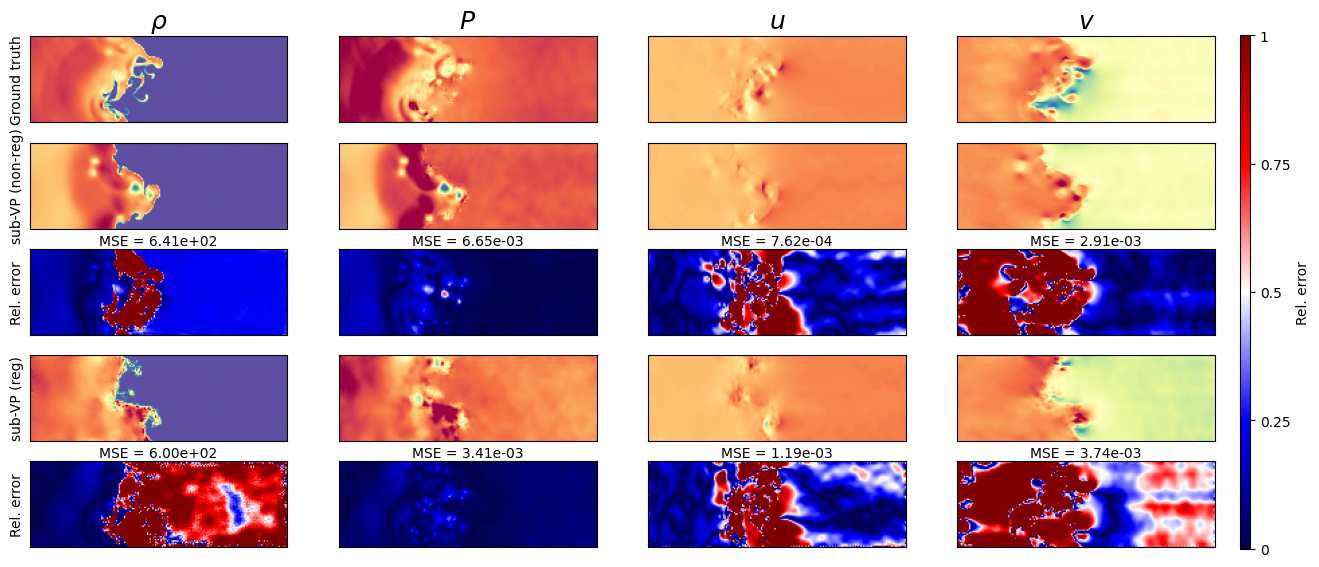

In [35]:
from results.plotting import compa_time_series_err

version = 1
time = 59
test_set = test_set_3
fields = [0,1,2,3]


sde = "subvpsde"
version = 3

# --- time series ---
GT = test_set["GT"]["pred"]
pred_1 = test_set["regFalse"][sde]["pred"][version]
pred_2 = test_set["regTrue"][sde]["pred"][version]
pred_3 = np.abs((pred_1 - GT )/ GT)
pred_4 = np.abs((pred_2 - GT )/ GT)

MSE_1 = test_set["regFalse"][sde]["MSE"][version]
MSE_2 = test_set["regTrue"][sde]["MSE"][version]

GT = np.expand_dims(GT[time, fields, :, :], axis=0)
pred_1 = np.expand_dims(pred_1[time, fields, :, :], axis=0)
pred_2 = np.expand_dims(pred_2[time, fields, :, :], axis=0)
pred_3 = np.expand_dims(pred_3[time, fields, :, :], axis=0)
pred_4 = np.expand_dims(pred_4[time, fields, :, :], axis=0)

time_steps, n_fields, Lx, Ly = GT.shape

vmin = [min(np.min(GT[:, i, ...]), np.min(pred_1[:, i, ...])) for i in range(n_fields)]
vmax = [max(np.max(GT[:, i, ...]), np.max(pred_1[:, i, ...])) for i in range(n_fields)]


MSE_gt = np.expand_dims(np.repeat([None], len(fields)), axis=0)
MSE_1 = np.expand_dims(["MSE = " + to_sci_2dp(x) for x in MSE_1[time, fields]], axis=0)
MSE_2 = np.expand_dims(["MSE = " + to_sci_2dp(x) for x in MSE_2[time, fields]], axis=0)
MSE_3 = np.expand_dims(np.repeat([None], len(fields)), axis=0)
MSE_4 = np.expand_dims(np.repeat([None], len(fields)), axis=0)


time_series = np.concatenate([GT, pred_1, pred_3, pred_2, pred_4], axis=0)

# --- labels ---
x_labels = np.concatenate([MSE_gt, MSE_1, MSE_3, MSE_2, MSE_4], axis=0)
y_labels = ["Ground truth", "sub-VP (non-reg)", "Rel. error", "sub-VP (reg)", "Rel. error"]

# --- titles ---
titles = fields_name
title_string = 'Best of each predictions at time '
suptitle = title_string + fr"$\tau={time}$"
saveKwargs = dict(save_string="../../TurbRad/turbRad_SDE_compa_fields=" + str(time) + ".png", dpi=600)


titleKwargs = dict(fontsize=18)
suptitleKwargs = dict(fontsize=18)
x_labelsKwargs = dict(fontsize=10)
y_labelsKwargs = dict(fontsize=10)
cbarKwargs = dict(fraction=0.024, pad=0.02)


vmin[1] *= .8
vmax[1] *= .8

vmin[2] *= 5
vmax[2] *= 1.

# vmin[3] *= .6
vmax[3] *= .6

compa_time_series_err(time_series, fields_name_latex, x_labels, y_labels=y_labels,
                  titleKwargs=titleKwargs, x_labelsKwargs=x_labelsKwargs, y_labelsKwargs=y_labelsKwargs,
                  coeff=coeff, vmin=vmin, vmax=vmax, ratio_xy=ratio_xy, cbarKwargs=cbarKwargs,
                  cmap=custom_jet_high_detail, rgba=None, suptitleKwargs=suptitleKwargs, **saveKwargs)

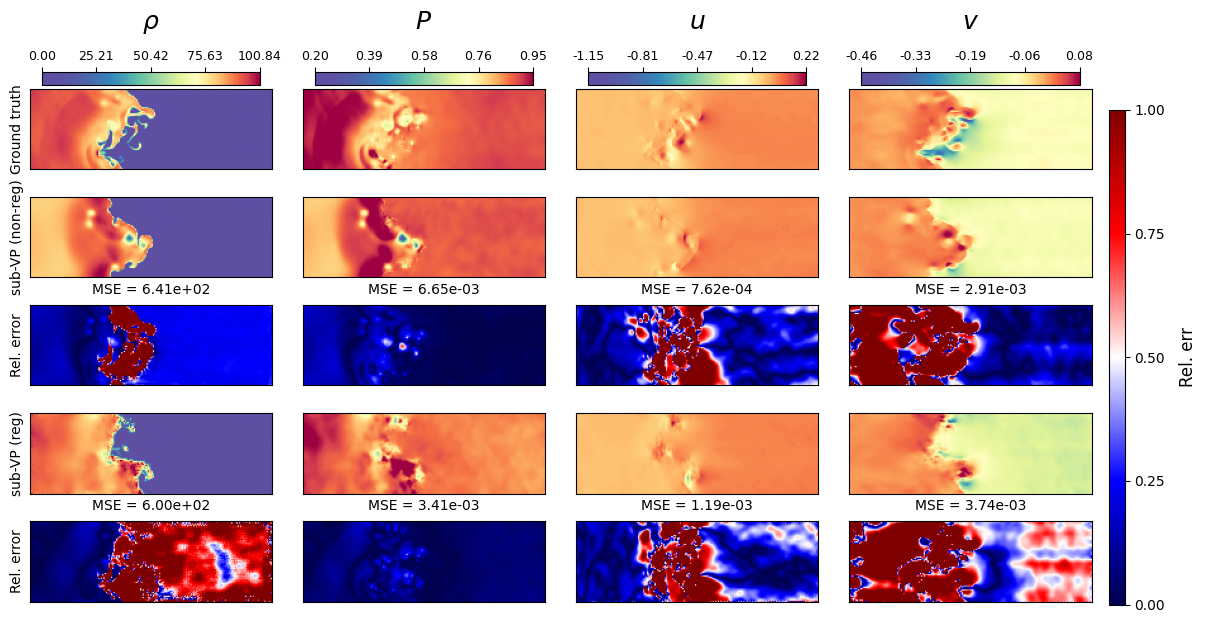

In [37]:
from results.plotting import compa_time_series_err_2

adjustKwargs = dict(wspace=-.35, hspace=.4)

left_cbar_args = [0.855, 0.15, 0.01, 0.7]  # [x0, y0, width, height]
top_cbar_args = [0.05, 1.05, 0.9, 0.15]  # [x0, y0, width, height]

vmin[0] *= 0.  # physical irregularities on scale

compa_time_series_err_2(time_series, fields_name_latex, x_labels, y_labels=y_labels, left_cbar_args=left_cbar_args, top_cbar_args=top_cbar_args, top_label_size=9,
                  titleKwargs=titleKwargs, x_labelsKwargs=x_labelsKwargs, y_labelsKwargs=y_labelsKwargs,
                  coeff=coeff, vmin=vmin, vmax=vmax, ratio_xy=ratio_xy, cbarKwargs=cbarKwargs,
                  cmap=custom_jet_high_detail, suptitleKwargs=suptitleKwargs, adjustKwargs=adjustKwargs, **saveKwargs)

In [11]:
from results.plotting import build_latex_table

latex = build_latex_table(
    test_cases       = test_cases,
    sde_names        = ["vpsde", "subvpsde", "vesde"],
    regularization   = regularization,
    measures         = ["MSE",
                        # "RE",
                        "pearson",
                        "KL_divergence",
                        "spectra_log_MSE"],
    measure_labels   = ["$\overline{MSE} \downarrow$",
                        # "$Re$",
                        "$\overline{pearson} \\uparrow$",
                        "$\overline{\mathbb{D}}_{KL} \downarrow$",
                        "$\\text{Log-MSE}$"],
    versions         = versions,
    sde_labels       = ["VP","sub‑VP","VE"],
    regu_labels      = {regularization[0]:"False", regularization[1]:"True"},
    highlight_lowest = [True, False, True, True],   # MSE ↓, ↑, ↓
    pms = [False, False, False, False],
    quart=False
)

print(latex)

\begin{tabular}{|c|c|ccc|ccc|ccc|ccc|}
\hline
\textbf{SDE type} & \textbf{Regularization} & \multicolumn{3}{c|}{$\overline{MSE} \downarrow$ ($10^{2}$)} & \multicolumn{3}{c|}{$\overline{pearson} \uparrow$ ($10^{-1}$)} & \multicolumn{3}{c|}{$\overline{\mathbb{D}}_{KL} \downarrow$ ($10^{1}$)} & \multicolumn{3}{c|}{$\text{Log-MSE}$ ($10^{-1}$)} \\
\cline{3-5}
\cline{6-8}
\cline{9-11}
\cline{12-14}
VP & False & \textbf{0.66} & 0.77 & 0.69 & \textbf{9.52} & 9.45 & 9.50 & 1.05 & 1.11 & 0.90 & 0.67 & 0.99 & \textbf{0.04} \\
sub‑VP & False & 0.74 & 1.00 & \textbf{0.58} & 9.48 & 9.30 & \textbf{9.59} & 1.24 & 1.32 & 0.93 & 1.50 & 2.06 & 0.06 \\
VE & False & 0.96 & 1.02 & 0.97 & 9.32 & 9.28 & 9.32 & \textbf{0.61} & \textbf{0.50} & \textbf{0.37} & 1.40 & 1.49 & 1.77 \\
\hline
VP & True & 0.72 & \textbf{0.76} & 0.77 & 9.48 & \textbf{9.46} & 9.46 & 1.20 & 1.05 & 0.92 & 1.18 & 1.02 & 0.37 \\
sub‑VP & True & 0.93 & 0.85 & 0.78 & 9.32 & 9.40 & 9.45 & 0.91 & 0.91 & 0.78 & \textbf{0.17} & \textbf{0.38} & 

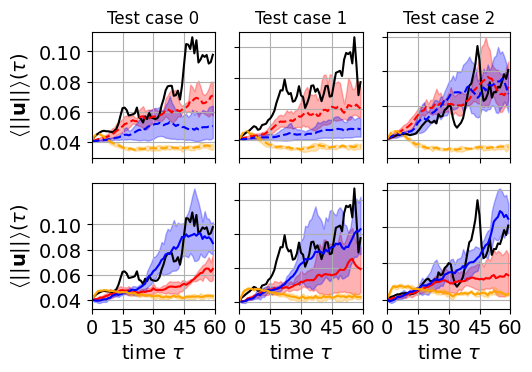

average over versions


In [12]:
test_cases = [test_set_1, test_set_2, test_set_3]

fac = 1.8
fig, axes = plt.subplots(2,3, figsize=(3*fac,2*fac))

str_y = r"$\left\langle \vert\vert \mathbf{u} \vert\vert \right\rangle (\tau)$"
axes[0, 0].set_ylabel(str_y, fontsize=fs_y_label)
axes[1, 0].set_ylabel(str_y, fontsize=fs_y_label)
colors = ["red", "blue", "orange"]


for i, ax in enumerate(axes[0, :]):

    test_case = test_cases[i]

    y = np.mean(test_case["GT"]["mag_U"], axis=(1,2))
    x = np.arange(0, len(y))
    ax.plot(x, y, label="Ground truth", color="black", linestyle="-", markersize=3, markevery=5)

    for ii, sde in enumerate(sde_names):
        versions = test_case["regFalse"][sde]["mag_U"].keys()
        data = np.stack([np.mean(test_case["regFalse"][sde]["mag_U"][v], axis=(1,2)) for v in versions ], axis=0)  # shape: (n_versions, n_points)
        mean_y = np.mean(data, axis=0)
        low, high = np.percentile(data, 5, axis=0), np.percentile(data, 95, axis=0)
        x = np.arange(len(mean_y))

        ax.plot(x, mean_y, color=colors[ii], linestyle="--")
        ax.fill_between(x, low, high, color=colors[ii], alpha=0.3)

    ax.set_title('Test case ' + str(i))
    if i>0: ax.set_yticklabels([])
    ax.set_xticklabels([])

    fac = 1
    support = k[fac:-fac]

for i, ax in enumerate(axes[1, :]):

    test_case = test_cases[i]

    y = np.mean(test_case["GT"]["mag_U"], axis=(1,2))
    x = np.arange(0, len(y))
    ax.plot(x, y, label="Ground truth", color="black", linestyle="-", markersize=3, markevery=5)

    for ii, sde in enumerate(sde_names):

        versions = test_case["regTrue"][sde]["mag_U"].keys()
        data = np.stack([np.mean(test_case["regTrue"][sde]["mag_U"][v], axis=(1,2)) for v in versions ], axis=0)  # shape: (n_versions, n_points)
        mean_y = np.mean(data, axis=0)
        low, high = np.percentile(data, 5, axis=0), np.percentile(data, 95, axis=0)
        x = np.arange(len(mean_y))

        ax.plot(x, mean_y, color=colors[ii], linestyle="-")
        ax.fill_between(x, low, high, color=colors[ii], alpha=0.3)


    ax.set_xlabel("time " r"$\tau$", fontsize=fs_ticks)
    # ax.set_title('Test case ' + str(i))

    if i>0: ax.set_yticklabels([])

for ax in axes.flatten():
    max_y = .1
    min_y = .04
    # ax.set_ylim(min_y, max_y)

    ax.set_xticks(np.arange(0, np.max(x)+2, 15))
    ax.set_yticks(np.arange(min_y, max_y + .01, .02))

    ax.set_xlim(0, 60)

    ax.grid(True)

plt.subplots_adjust(hspace=.2, )  # vertical spacing
plt.subplots_adjust(wspace=.2, )  # horizontal spacing

# axes[0,2].plot([], [], linestyle="--", label="Non-regularized", color="black")
# axes[0,2].plot([], [], linestyle="-", label="Regularized", color="black")
# axes[0,2].scatter([], [], label="VP SDE", color=colors[0])
# axes[0,2].scatter([], [], label="sub-VP SDE", color=colors[1])
# axes[0,2].scatter([], [], label="VE SDE", color=colors[2])


for ax in axes.flat:
    ax.tick_params(axis='both', labelsize=fs_ticks)


plt.savefig('../../TurbRad/turbRad_mean.png', dpi=500, bbox_inches='tight')  # bbox_inches='tight' or the legend is cut off


plt.show()
print('average over versions')

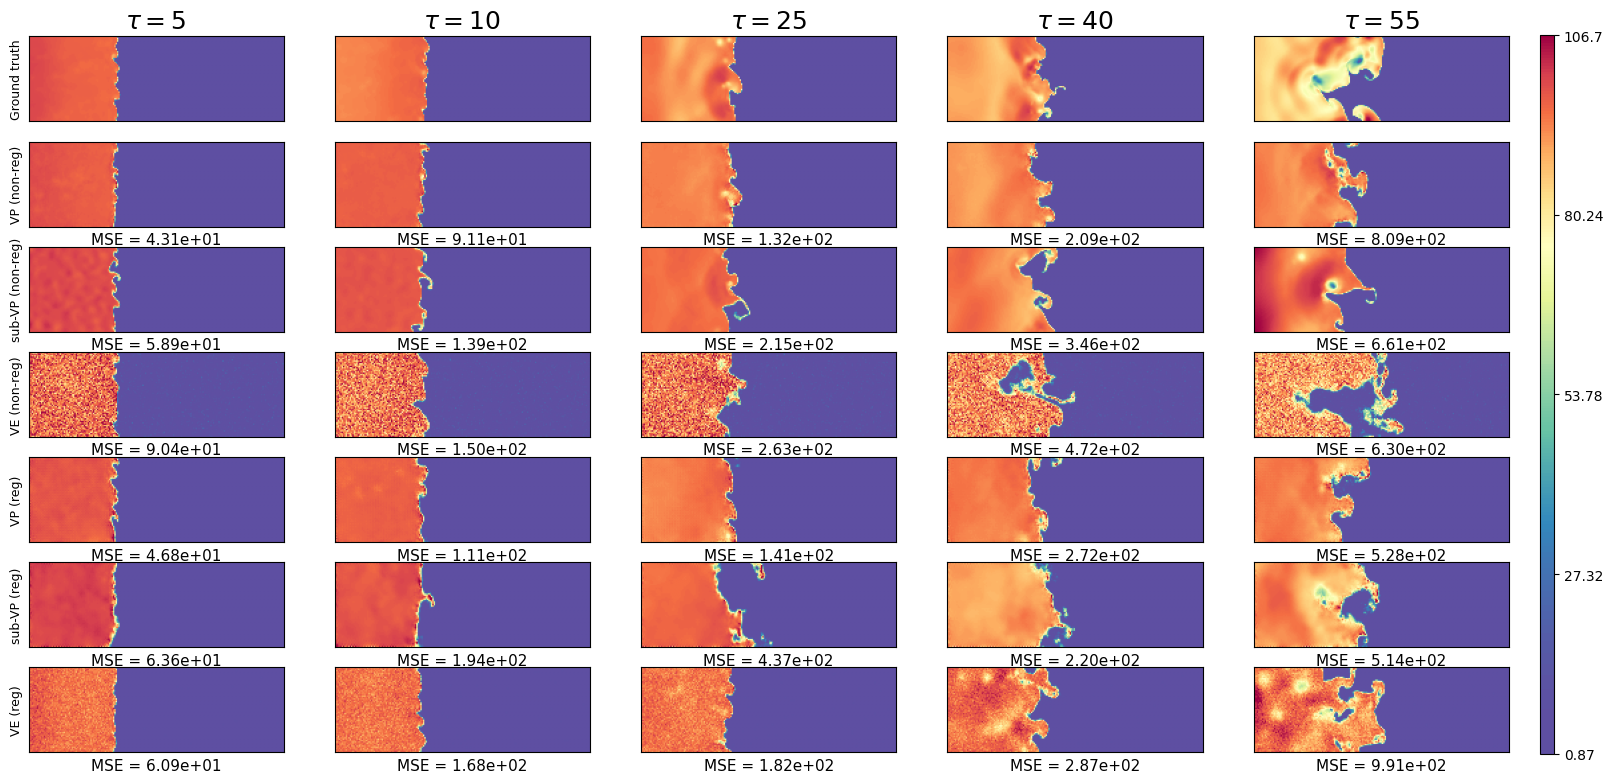

In [13]:
from results.plotting import compa_time_series

version = 1
test_set = test_set_1
field = 0
times = [5, 10, 25, 40, 55]


GT = test_set["GT"]["pred"][times, field, ...]
MSE_gt = np.repeat([None], len(times))


vmin = np.repeat(np.min(GT[:, field]), len(times))
vmax = np.repeat(np.max(GT[:, field]), len(times))

time_series = np.expand_dims(GT, axis=0)
x_labels = np.expand_dims(MSE_gt, axis=0)
y_labels = ["Ground truth"]

for regu in regularization:

    reg_lab = " (non-reg)" if regu == "regFalse" else " (reg)"
    sde_labs = ["VP", "sub-VP", "VE"]

    for sde, sde_lab in zip(sde_names, sde_labs):
        pred = test_set[regu][sde]["pred"][version][times, field, ...]
        pred = np.expand_dims(pred, axis=0)
        time_series = np.concatenate([time_series, pred], axis=0)

        MSE = test_set[regu][sde]["MSE"][version][times, field]
        MSE = np.expand_dims(["MSE = " + to_sci_2dp(x) for x in MSE], axis=0)
        x_labels = np.concatenate([x_labels, MSE], axis=0)
        y_labels.append(sde_lab + reg_lab)


# --- titles ---
titles = [fr"$\tau={time}$" for time in times]
title_string = 'pred'
# suptitle = "Prediction for " + fields_name[field]
suptitle = ""
saveKwargs = dict(save_string="../../TurbRad/turbRad_time_series_rho" + ".png", dpi=250)


titleKwargs = dict(fontsize=18)
suptitleKwargs = dict(fontsize=18)
x_labelsKwargs = dict(fontsize=11)
y_labelsKwargs = dict(fontsize=9)
cbarKwargs = dict(fraction=0.025, pad=0.02)



compa_time_series(time_series, titles, x_labels, y_labels=y_labels,
                  titleKwargs=titleKwargs, x_labelsKwargs=x_labelsKwargs, y_labelsKwargs=y_labelsKwargs,
                  coeff=coeff, vmin=vmin, vmax=vmax, ratio_xy=ratio_xy, cbarKwargs=cbarKwargs, cbar_labels=np.round(np.linspace(vmin[0], vmax[0], 5), 2),
                  cmap=custom_jet_high_detail, rgba=None, suptitle=suptitle, suptitleKwargs=suptitleKwargs, **saveKwargs)